#  Deep Learning-Based Semantic Segmentation Techniques on Carla Dataset

## Loading libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/thesis/256_np_array /content/np_files

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [4]:
#Import builtin libraries
import os


In [5]:
#Import third party libraries
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

#same procedure for "froms"
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
# from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchmetrics.classification import Dice
from torchmetrics import JaccardIndex, Accuracy
from torchmetrics.segmentation import MeanIoU
from tqdm.auto import tqdm



## Set the Random State


In [6]:
torch.manual_seed(1)
# Set numpy random seed, if issues use random state
np.random.seed(1)

## Loading the Data

In [ ]:
# Base directory containing all data parts
base_dir = 'carla-capture'

#list of subdirectories
data_parts = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']

### obtaining Path

In [ ]:
#making a list to store images
image_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for images
    datadir_images = os.path.join(base_dir, part, 'CameraRGB/')
    # Load the image paths in a list if the directory exists
    if os.path.exists(datadir_images):
        filenames_images = [name for name in os.listdir(datadir_images) if name.endswith('.png')]
        # Combine the image path with the OS path
        image_paths.extend([os.path.join(datadir_images, filename) for filename in filenames_images])


# for path in image_paths:
#     print(path)
print(len(image_paths))

In [ ]:
# same procedur for labels
label_paths = []

# Loop through each data part subdirectory
for part in data_parts:
    # Set the directory for labels
    datadir_labels = os.path.join(base_dir, part, 'CameraSeg/')
    # Load the label paths in a list if the directory exists
    if os.path.exists(datadir_labels):
        filenames_labels = [name for name in os.listdir(datadir_labels) if name.endswith('.png')]
        # Combine the label path with the OS path
        label_paths.extend([os.path.join(datadir_labels, name) for name in filenames_labels])


# for path in label_paths:
#     print(path)



print(len(label_paths))

## Displaying the data

In [ ]:
# Load images and convert them from BGR to RGB
# Images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]


# Convert Images to numpy array then convert them from BGR to RGB
# Images= np.array(Images)[..., ::-1]

x = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]
y = [cv2.imread(path) for path in label_paths]


In [ ]:
x = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in x]
y = [cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA) for img in y]

## saving the Data

In [ ]:
# Convert images and labels to numpy arrays
x = np.array(Images)
y = np.array(labels)


In [ ]:
# x = x.reshape( x.shape[0], x.shape[3], x.shape[1], x.shape[2])
#y = y.reshape( y.shape[0], y.shape[3], y.shape[1], y.shape[2])

x = x.transpose(0, 3, 1, 2)

In [ ]:
#split training and validation_test
x_train, x_valtest, y_train, y_valtest=train_test_split(x, y , test_size= 0.4, random_state= 1)

# Split validation-test to validation AND test
x_val, x_test, y_val, y_test= train_test_split(x_valtest, y_valtest, test_size= 0.5, random_state= 1)

## Pytroch Data Loading

In [7]:
class loadDatasets(Dataset):
    def __init__(self, image_path, label_path):

        self.image = np.load(image_path)
        self.label= np.load(label_path)

    def __getitem__(self, index):

        x = self.image[index, :, :, :]
        x = torch.tensor(x, dtype=torch.float32)


        y = self.label[index, :, :, :]
        y = np.max(y, axis=2)
        y= torch.tensor(y, dtype=torch.long)

        return x, y

    def __len__(self):
        return len(self.image)

## Defining SegNet

### CNN block

In [8]:
#using this website: https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


### Eecoderblock

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvBlock(in_channels if i == 0 else out_channels, out_channels, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.pool(x)
        return x, indices


### DecoderBlock

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, is_classifier=False):
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
          if i == depth - 1 and is_classifier:
              self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
          elif i == depth - 1:
              self.layers.append(ConvBlock(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
          else:
              self.layers.append(ConvBlock(in_channels, in_channels, kernel_size=kernel_size, padding=padding))

    def forward(self, x, indices):
        x = self.unpool(x, indices)
        for layer in self.layers:
            x = layer(x)
        return x


### SegNet

In [11]:
class SegNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=1, feature_sizes=[64, 128, 256, 512, 4096]):
        super(SegNet, self).__init__()

        # Encoder
        #ps: with depth= 3(this sequence of conv, norm, relu id repeatef 3 times)
        self.encoder1 = EncoderBlock(input_channels, feature_sizes[0])
        self.encoder2 = EncoderBlock(feature_sizes[0], feature_sizes[1])
        self.encoder3 = EncoderBlock(feature_sizes[1], feature_sizes[2], depth=3)
        self.encoder4 = EncoderBlock(feature_sizes[2], feature_sizes[3], depth=3)

        # Bottleneck
        self.bottleneck_encoder = EncoderBlock(feature_sizes[3], feature_sizes[4], depth=3)
        self.bottleneck_decoder = DecoderBlock(feature_sizes[4], feature_sizes[3], depth=3)

        # Decoder
        self.decoder1 = DecoderBlock(feature_sizes[3], feature_sizes[2], depth=3)
        self.decoder2 = DecoderBlock(feature_sizes[2], feature_sizes[1], depth=3)
        self.decoder3 = DecoderBlock(feature_sizes[1], feature_sizes[0])
        self.classifier_layer = DecoderBlock(feature_sizes[0], num_classes, is_classifier=True)

    def forward(self, x):
        # Encoder path
        x1, indices1 = self.encoder1(x)
        x2, indices2 = self.encoder2(x1)
        x3, indices3 = self.encoder3(x2)
        x4, indices4 = self.encoder4(x3)

        # Bottleneck
        bottleneck, bottleneck_indices = self.bottleneck_encoder(x4)
        bottleneck = self.bottleneck_decoder(bottleneck, bottleneck_indices)

        # Decoder path
        x = self.decoder1(bottleneck, indices4)
        x = self.decoder2(x, indices3)
        x = self.decoder3(x, indices2)
        output = self.classifier_layer(x, indices1)
        return output

## Training the models

In [12]:
# Create a device variable that checks if your computer has GPU or CPU and uses which is available
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load the data

In [13]:
# Load the training data
train_data = loadDatasets("/content/np_files/images_train.npy",
                          "/content/np_files/labels_train.npy" )
# Load the validation data
val_data= loadDatasets("/content/np_files/images_val.npy",
                       "/content/np_files/labels_val.npy")
# Load the test data
test_data= loadDatasets("/content/np_files/images_test.npy",
                        "/content/np_files/labels_test.npy")

In [ ]:
# # Load the training data
# train_data = loadDatasets("images_train.npy","labels_train.npy" )

In [ ]:
# # Load the validation data
# val_data= loadDatasets("images_val.npy","labels_val.npy")

In [ ]:
# # Load the test data
# test_data= loadDatasets("images_test.npy","labels_test.npy")

### Creating dataloaders

In [14]:
# definig variables
BATCH_SIZE = 8
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 13
FEATURES= [64, 128, 256, 512, 4096]
EPOCHS= 31

In [15]:
# Create the train data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE ,shuffle=True)

In [16]:
# Create the validation data loader
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=False)

In [17]:
# Create the test data loader
test_loader = DataLoader(test_data, batch_size= BATCH_SIZE,shuffle=False)

### Defining variables to make things easy

### Defining the model

In [18]:
#SegNet
segnet_model = SegNet(input_channels=INPUT_CHANNELS, num_classes=OUTPUT_CHANNELS, feature_sizes=FEATURES)


In [19]:
# Move the model to device
segnet_model.to(device)

SegNet(
  (encoder1): EncoderBlock(
    (layers): ModuleList(
      (0): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (layers): ModuleList(
      (0): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(128, 128, kernel_s

In [20]:
# Define an optimizer
# https://pytorch.org/docs/stable/optim.html
LR= 0.0001
segnet_optimizer = optim.Adam(segnet_model.parameters(), lr=LR)

#defining a scaler
scaler = torch.cuda.amp.GradScaler()

In [21]:
# Define a loss function
# see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion =torch.nn.CrossEntropyLoss()

### Define metric

In [22]:
# acc_train =  MulticlassAccuracy().to(device)
miou_train = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)
dice = Dice(num_classes=13, average='micro').to(device)

# acc_val = MulticlassAccuracy().to(device)
miou_val = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)

In [23]:
softmax = nn.Softmax(dim=1)

### The trianing !

In [ ]:
# Create two lists for training and validation loss 
train_loss=[]
val_loss=[]

# Create two lists for storing mIoU (training and validation)
train_miou= []
val_miou= []

# # Create two lists to store accuracies (training and validation)
# train_accuracy=[]
# val_accuracy= []

# Create two lists to store dice score/coefficient (training and validation)
train_dice=[]
val_dice=[]



# Define a function that will have the training code
def train():

  # Create a for loop to go over each epoch
  for epoch in range(EPOCHS):
    t_dice= 0
    v_dice=0
    miou=0
    segnet_model_loss=0
    v_miou=0
    segnet_model_loss_val=0
    # Now we need to go over every batch in data loader
    for image, label in tqdm(train_loader):
      image= image.to(device)
      label= label.to(device)
      # train/update the neural network model

      with torch.cpu.amp.autocast():
        pred = segnet_model(image)
      # get the predictions of the model
      # Compute the loss between prediction and label using loss function
      ### PREDICTION WILL HAVE DIFFERENT SHAPE THEN LABEL
      ### E.G LABEL IS 256x256, PRED IS 488x488
      ### use center_crop(pred[0], (label.shape[2], x.label[3]) )
      ### THE BIGGER IMAGE IS CROPPED AND THE DIMENSIONS ARE OF SMALLER
      # print(pred.shape, label.shape)
      #pred = center_crop(pred, (label.shape[1], label.shape[2]))
        segnet_model_loss= criterion(pred, label)
      # backward
      segnet_optimizer.zero_grad()
      scaler.scale(segnet_model_loss).backward()
      scaler.step(segnet_optimizer)
      scaler.update()


      # # Do a backward pass on our model
      # segnet_model_loss.backward()
      # # Take a step of optimizer
      # segnet_optimizer.step()

    # Put the model in validaton mode, model_variable_name.eval()
    segnet_model.eval()
    # make sure pytorch does not compute gradeients, this can be done as below
    with torch.no_grad():
      for image, label in tqdm(train_loader):
        image= image.to(device)
        label= label.to(device)
        # Get the prediction from the model
        pred= segnet_model(image)
        # Compute the loss between prediction and label using loss function

        #pred = center_crop(pred, (label.shape[1], label.shape[2]))
        segnet_model_loss= criterion(pred, label)

        pred = torch.argmax(softmax(pred),axis=1)
        # Compute the jaccard index between prediction and label 
        miou += miou_train(pred, label)

        # compute the accuracy between prediction and label
        t_dice += dice(pred, label).item()

    # Append the loss to the validation loss list
    train_loss.append(segnet_model_loss.item()/len(train_loader))
    # Append the val mIoU (average jaccard index) to val mIoU list
    train_miou.append(miou_train.compute())
    # Append the average accuray to the val accuracy list
    train_dice.append(t_dice/len(train_loader))

    # Print the average val loss
    print(f"The train average loss for {epoch} is: {segnet_model_loss.item()/ len(train_loader)}")
    # Print the val mIoU
    print(f"The train miou for {epoch} is: {train_miou[epoch]}")
    # Print the train accuracy
    print(f"The train dice score for {epoch} is:{train_dice[epoch]}")

    #reset
    dice.reset()
    miou_train.reset()

    with torch.no_grad():
      # Go over every batch in validation loader, use for loop
      for image, label in tqdm(val_loader):
        image= image.to(device)
        label= label.to(device)

        # # get the predictions of the model
        pred= segnet_model(image)

        # Compute the loss between prediction and label using loss function
        segnet_model_loss_val += criterion(pred, label)

        pred = torch.argmax(softmax(pred),axis=1)
        # Compute the jaccard index between prediction
        v_miou += miou_val(pred, label)

        # compute the dice score between prediction and label 
        v_dice += dice(pred, label).item()


    # Append the loss to the validation loss list
    val_loss.append(segnet_model_loss_val/ len(val_loader))
    # Append the val mIoU to val mIoU list
    val_miou.append(miou_val.compute())
    # Append the average accuray to the val accuracy list
    val_dice.append(v_dice/len(val_loader))

    # Print the average val loss
    print(f"The average val loss for {epoch} is: {segnet_model_loss_val/ len(val_loader)}")
    # Print the val mIoU
    print(f"The val miou for {epoch} is: {miou_val.compute()}")
    # Print the val accuracy
    print(f"The val dice score for {epoch} is:{val_dice[epoch]}")

    #reset
    dice.reset()
    miou_val.reset()


    # Save the model after every 10 epochs
    if epoch % 5 == 0:
      save_path = "Model Weights/segnet_model/"
      segnet_model_epoch = f"segnet_model_epoch{epoch}.pth"
      # Create a directory if it does not exist
      if not os.path.exists(save_path):
          os.makedirs(save_path, exist_ok = True)
      # Save the model to this directory
      torch.save({'segnet_model_state_dict':segnet_model.state_dict()}, save_path + segnet_model_epoch)
#,'segnet_optimizer_state_dict': segnet_optimizer.state_dict()}
train()

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 0 is: 0.0013058204650878906
The train miou for 0 is: tensor([0.9050, 0.4954, 0.0000, 0.0000, 0.0000, 0.0000, 0.0188, 0.8693, 0.6327,
        0.5408, 0.9413, 0.0000, 0.0000], device='cuda:0')
The train dice score for 0 is:0.8624509785970053


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 0 is: 0.4991131126880646
The val miou for 0 is: tensor([0.9051, 0.4777, 0.0000, 0.0000, 0.0000, 0.0000, 0.0188, 0.8688, 0.6343,
        0.5332, 0.9418, 0.0000, 0.0000], device='cuda:0')
The val dice score for 0 is:0.8623106536865235


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 1 is: 0.001498812198638916
The train miou for 1 is: tensor([8.7237e-01, 3.4313e-01, 1.7180e-06, 7.4763e-07, 0.0000e+00, 0.0000e+00,
        2.6112e-01, 8.5577e-01, 5.9162e-01, 4.1300e-01, 9.2656e-01, 0.0000e+00,
        0.0000e+00], device='cuda:0')
The train dice score for 1 is:0.8215076649983724


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 1 is: 0.5962750315666199
The val miou for 1 is: tensor([8.7382e-01, 3.3153e-01, 4.7073e-06, 0.0000e+00, 0.0000e+00, 4.1841e-06,
        2.6194e-01, 8.5441e-01, 5.9261e-01, 4.0648e-01, 9.2746e-01, 0.0000e+00,
        0.0000e+00], device='cuda:0')
The val dice score for 1 is:0.8215680999755859


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 2 is: 0.0012859971523284913
The train miou for 2 is: tensor([8.8213e-01, 4.1653e-01, 2.9022e-04, 5.3230e-04, 1.0816e-04, 2.3569e-04,
        3.2604e-01, 8.6782e-01, 6.1979e-01, 5.0239e-01, 9.3275e-01, 2.5741e-06,
        0.0000e+00], device='cuda:0')
The train dice score for 2 is:0.8477877349853515


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 2 is: 0.5186001062393188
The val miou for 2 is: tensor([8.8258e-01, 4.0185e-01, 2.4577e-04, 5.3101e-04, 7.8186e-05, 1.8114e-04,
        3.2402e-01, 8.6542e-01, 6.2175e-01, 4.9744e-01, 9.3179e-01, 0.0000e+00,
        0.0000e+00], device='cuda:0')
The val dice score for 2 is:0.8473390197753906


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 3 is: 0.001149705410003662
The train miou for 3 is: tensor([9.0745e-01, 4.5960e-01, 8.6670e-04, 3.5056e-03, 4.3581e-04, 1.9351e-03,
        3.4670e-01, 8.8340e-01, 6.2684e-01, 5.4641e-01, 9.4224e-01, 5.7922e-03,
        0.0000e+00], device='cuda:0')
The train dice score for 3 is:0.861035883585612


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 3 is: 0.4723358154296875
The val miou for 3 is: tensor([9.0793e-01, 4.4754e-01, 8.0422e-04, 3.3842e-03, 4.0941e-04, 1.7166e-03,
        3.4477e-01, 8.8231e-01, 6.2860e-01, 5.4439e-01, 9.4313e-01, 5.3368e-03,
        0.0000e+00], device='cuda:0')
The val dice score for 3 is:0.8616681365966797


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 4 is: 0.0012191591262817384
The train miou for 4 is: tensor([0.9128, 0.4962, 0.0067, 0.0274, 0.0020, 0.0038, 0.3651, 0.8916, 0.6468,
        0.5993, 0.9368, 0.0799, 0.0000], device='cuda:0')
The train dice score for 4 is:0.8709608306884765


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 4 is: 0.4404321312904358
The val miou for 4 is: tensor([0.9129, 0.4827, 0.0068, 0.0263, 0.0019, 0.0034, 0.3629, 0.8889, 0.6464,
        0.5921, 0.9357, 0.0779, 0.0000], device='cuda:0')
The val dice score for 4 is:0.870353515625


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 5 is: 0.0010671585400899252
The train miou for 5 is: tensor([0.9115, 0.4981, 0.0055, 0.0216, 0.0030, 0.0082, 0.3791, 0.8881, 0.6456,
        0.6328, 0.9433, 0.0893, 0.0000], device='cuda:0')
The train dice score for 5 is:0.8761490173339844


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 5 is: 0.426241397857666
The val miou for 5 is: tensor([0.9108, 0.4815, 0.0054, 0.0188, 0.0029, 0.0075, 0.3742, 0.8831, 0.6410,
        0.6222, 0.9415, 0.0847, 0.0000], device='cuda:0')
The val dice score for 5 is:0.8744190368652344


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 6 is: 0.0008270422617594401
The train miou for 6 is: tensor([0.9260, 0.5491, 0.0329, 0.0580, 0.0068, 0.0158, 0.3790, 0.9000, 0.6521,
        0.6698, 0.9565, 0.1297, 0.0000], device='cuda:0')
The train dice score for 6 is:0.8889271036783855


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 6 is: 0.38309726119041443
The val miou for 6 is: tensor([0.9253, 0.5324, 0.0332, 0.0536, 0.0065, 0.0145, 0.3764, 0.8951, 0.6480,
        0.6612, 0.9555, 0.1199, 0.0000], device='cuda:0')
The val dice score for 6 is:0.8871294860839843


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 7 is: 0.0010271790822347006
The train miou for 7 is: tensor([0.9350, 0.5750, 0.0405, 0.0666, 0.0154, 0.0230, 0.3498, 0.9009, 0.6609,
        0.6410, 0.9490, 0.1925, 0.0000], device='cuda:0')
The train dice score for 7 is:0.8912832590738933


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 7 is: 0.36713308095932007
The val miou for 7 is: tensor([0.9345, 0.5555, 0.0414, 0.0607, 0.0149, 0.0209, 0.3470, 0.8985, 0.6615,
        0.6362, 0.9488, 0.1828, 0.0000], device='cuda:0')
The val dice score for 7 is:0.8902741546630859


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 8 is: 0.0008759071826934814
The train miou for 8 is: tensor([0.9324, 0.5908, 0.0863, 0.1122, 0.0064, 0.0294, 0.4127, 0.9079, 0.6878,
        0.6757, 0.9621, 0.1950, 0.0000], device='cuda:0')
The train dice score for 8 is:0.8983663380940755


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 8 is: 0.3450874388217926
The val miou for 8 is: tensor([0.9314, 0.5712, 0.0891, 0.1047, 0.0061, 0.0272, 0.4104, 0.9049, 0.6851,
        0.6671, 0.9605, 0.1809, 0.0000], device='cuda:0')
The val dice score for 8 is:0.8966412200927735


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 9 is: 0.0007234748204549154
The train miou for 9 is: tensor([0.9400, 0.6101, 0.1282, 0.1485, 0.0177, 0.0504, 0.4022, 0.9132, 0.7024,
        0.7215, 0.9626, 0.2559, 0.0000], device='cuda:0')
The train dice score for 9 is:0.904843983968099


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 9 is: 0.3229375183582306
The val miou for 9 is: tensor([0.9389, 0.5894, 0.1297, 0.1360, 0.0169, 0.0471, 0.3976, 0.9090, 0.6987,
        0.7114, 0.9605, 0.2377, 0.0000], device='cuda:0')
The val dice score for 9 is:0.9022998962402343


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 10 is: 0.0008014644781748454
The train miou for 10 is: tensor([9.4933e-01, 6.2791e-01, 1.4372e-01, 1.7360e-01, 2.2735e-02, 5.6749e-02,
        4.0599e-01, 9.1703e-01, 7.1785e-01, 7.1201e-01, 9.6921e-01, 2.8054e-01,
        1.2304e-05], device='cuda:0')
The train dice score for 10 is:0.9105407409667968


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 10 is: 0.30346056818962097
The val miou for 10 is: tensor([9.4777e-01, 6.0501e-01, 1.4604e-01, 1.5653e-01, 2.2280e-02, 5.3494e-02,
        4.0246e-01, 9.1225e-01, 7.1093e-01, 7.0181e-01, 9.6654e-01, 2.5529e-01,
        1.3986e-05], device='cuda:0')
The val dice score for 10 is:0.9074786682128906


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 11 is: 0.0007032155195871989
The train miou for 11 is: tensor([0.9462, 0.6400, 0.1571, 0.1924, 0.0244, 0.0583, 0.4222, 0.9170, 0.7233,
        0.7278, 0.9725, 0.2923, 0.0015], device='cuda:0')
The train dice score for 11 is:0.9129645589192709


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 11 is: 0.29497212171554565
The val miou for 11 is: tensor([0.9444, 0.6138, 0.1576, 0.1712, 0.0238, 0.0551, 0.4193, 0.9125, 0.7164,
        0.7160, 0.9696, 0.2695, 0.0016], device='cuda:0')
The val dice score for 11 is:0.9094793090820312


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 12 is: 0.0007475494543711345
The train miou for 12 is: tensor([0.9516, 0.6445, 0.1534, 0.1965, 0.0120, 0.0664, 0.4086, 0.9199, 0.7249,
        0.7082, 0.9700, 0.2818, 0.0134], device='cuda:0')
The train dice score for 12 is:0.9131405690511067


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 12 is: 0.2927415370941162
The val miou for 12 is: tensor([0.9501, 0.6189, 0.1535, 0.1731, 0.0118, 0.0628, 0.4053, 0.9157, 0.7188,
        0.6979, 0.9674, 0.2618, 0.0137], device='cuda:0')
The val dice score for 12 is:0.9099100036621094


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 13 is: 0.0006046842734018961
The train miou for 13 is: tensor([0.9554, 0.6283, 0.1731, 0.1966, 0.0170, 0.0905, 0.4305, 0.9242, 0.7308,
        0.7407, 0.9779, 0.3161, 0.0696], device='cuda:0')
The train dice score for 13 is:0.9167309977213541


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 13 is: 0.2821592688560486
The val miou for 13 is: tensor([0.9538, 0.6044, 0.1720, 0.1685, 0.0163, 0.0844, 0.4263, 0.9189, 0.7215,
        0.7292, 0.9741, 0.2864, 0.0688], device='cuda:0')
The val dice score for 13 is:0.9128289794921876


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 14 is: 0.0005395814577738444
The train miou for 14 is: tensor([0.9557, 0.6606, 0.1870, 0.2297, 0.0417, 0.0844, 0.4297, 0.9227, 0.7380,
        0.7443, 0.9765, 0.3183, 0.1022], device='cuda:0')
The train dice score for 14 is:0.9191863301595052


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 14 is: 0.27061381936073303
The val miou for 14 is: tensor([0.9542, 0.6354, 0.1859, 0.2000, 0.0405, 0.0792, 0.4261, 0.9178, 0.7290,
        0.7319, 0.9729, 0.2923, 0.0999], device='cuda:0')
The val dice score for 14 is:0.9154570007324219


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 15 is: 0.0008078443209330241
The train miou for 15 is: tensor([0.9582, 0.6736, 0.1985, 0.2543, 0.0304, 0.1234, 0.4246, 0.9246, 0.7484,
        0.7473, 0.9755, 0.3387, 0.1171], device='cuda:0')
The train dice score for 15 is:0.9219082641601563


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 15 is: 0.2617403566837311
The val miou for 15 is: tensor([0.9562, 0.6453, 0.1965, 0.2219, 0.0293, 0.1165, 0.4205, 0.9193, 0.7377,
        0.7341, 0.9712, 0.3111, 0.1122], device='cuda:0')
The val dice score for 15 is:0.9175721740722657


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 16 is: 0.0006222764253616333
The train miou for 16 is: tensor([0.9594, 0.6665, 0.2018, 0.2598, 0.0307, 0.1031, 0.4380, 0.9273, 0.7516,
        0.7552, 0.9774, 0.3479, 0.1250], device='cuda:0')
The train dice score for 16 is:0.9235382283528646


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 16 is: 0.2554313838481903
The val miou for 16 is: tensor([0.9572, 0.6390, 0.1993, 0.2212, 0.0301, 0.0950, 0.4343, 0.9224, 0.7410,
        0.7416, 0.9731, 0.3175, 0.1172], device='cuda:0')
The val dice score for 16 is:0.9190833282470703


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 17 is: 0.0004857486089070638
The train miou for 17 is: tensor([0.9592, 0.6796, 0.2016, 0.2850, 0.0294, 0.1393, 0.4468, 0.9297, 0.7553,
        0.7667, 0.9815, 0.3602, 0.1403], device='cuda:0')
The train dice score for 17 is:0.9260383911132812


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 17 is: 0.2481243908405304
The val miou for 17 is: tensor([0.9570, 0.6496, 0.1984, 0.2446, 0.0285, 0.1303, 0.4418, 0.9245, 0.7435,
        0.7524, 0.9777, 0.3303, 0.1324], device='cuda:0')
The val dice score for 17 is:0.9212237396240235


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 18 is: 0.0006057233810424805
The train miou for 18 is: tensor([0.9578, 0.6765, 0.2071, 0.2728, 0.0274, 0.1384, 0.4472, 0.9293, 0.7518,
        0.7501, 0.9807, 0.3538, 0.1411], device='cuda:0')
The train dice score for 18 is:0.9233397115071614


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 18 is: 0.25852033495903015
The val miou for 18 is: tensor([0.9557, 0.6451, 0.2038, 0.2379, 0.0263, 0.1296, 0.4438, 0.9244, 0.7412,
        0.7358, 0.9761, 0.3206, 0.1345], device='cuda:0')
The val dice score for 18 is:0.9183154144287109


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 19 is: 0.0007847488721211751
The train miou for 19 is: tensor([0.9567, 0.6607, 0.1831, 0.2527, 0.0196, 0.1156, 0.4307, 0.9239, 0.7444,
        0.7337, 0.9769, 0.3445, 0.1303], device='cuda:0')
The train dice score for 19 is:0.9196845194498698


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 19 is: 0.26806527376174927
The val miou for 19 is: tensor([0.9548, 0.6327, 0.1807, 0.2186, 0.0184, 0.1091, 0.4261, 0.9191, 0.7345,
        0.7221, 0.9730, 0.3179, 0.1282], device='cuda:0')
The val dice score for 19 is:0.9153979949951172


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 20 is: 0.0004437187910079956
The train miou for 20 is: tensor([0.9598, 0.6826, 0.2082, 0.2793, 0.0375, 0.1425, 0.4507, 0.9285, 0.7535,
        0.7685, 0.9820, 0.3624, 0.1379], device='cuda:0')
The train dice score for 20 is:0.9264843393961588


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 20 is: 0.24533693492412567
The val miou for 20 is: tensor([0.9577, 0.6544, 0.2049, 0.2387, 0.0364, 0.1333, 0.4454, 0.9234, 0.7420,
        0.7557, 0.9777, 0.3332, 0.1256], device='cuda:0')
The val dice score for 20 is:0.9218208618164062


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 21 is: 0.0006265068054199219
The train miou for 21 is: tensor([0.9619, 0.6889, 0.2236, 0.2942, 0.0291, 0.1631, 0.4529, 0.9284, 0.7614,
        0.7723, 0.9819, 0.3799, 0.1573], device='cuda:0')
The train dice score for 21 is:0.9275532786051432


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 21 is: 0.24106107652187347
The val miou for 21 is: tensor([0.9594, 0.6590, 0.2203, 0.2538, 0.0287, 0.1500, 0.4489, 0.9234, 0.7489,
        0.7590, 0.9774, 0.3472, 0.1470], device='cuda:0')
The val dice score for 21 is:0.9226048431396484


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 22 is: 0.0004099482297897339
The train miou for 22 is: tensor([0.9635, 0.6947, 0.2239, 0.3034, 0.0596, 0.1589, 0.4558, 0.9320, 0.7694,
        0.7718, 0.9827, 0.3866, 0.1752], device='cuda:0')
The train dice score for 22 is:0.9298352813720703


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 22 is: 0.23441901803016663
The val miou for 22 is: tensor([0.9611, 0.6648, 0.2204, 0.2582, 0.0579, 0.1449, 0.4508, 0.9267, 0.7558,
        0.7577, 0.9785, 0.3527, 0.1584], device='cuda:0')
The val dice score for 22 is:0.9246907958984375


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 23 is: 0.0006557541688283284
The train miou for 23 is: tensor([0.9629, 0.6849, 0.2229, 0.3028, 0.0503, 0.1554, 0.4619, 0.9320, 0.7691,
        0.7815, 0.9810, 0.3819, 0.1748], device='cuda:0')
The train dice score for 23 is:0.9291527455647787


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 23 is: 0.23762159049510956
The val miou for 23 is: tensor([0.9607, 0.6551, 0.2186, 0.2591, 0.0482, 0.1430, 0.4564, 0.9261, 0.7558,
        0.7665, 0.9768, 0.3496, 0.1593], device='cuda:0')
The val dice score for 23 is:0.9238821411132813


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 24 is: 0.000546652356783549
The train miou for 24 is: tensor([0.9597, 0.6727, 0.2140, 0.2850, 0.0294, 0.1525, 0.4437, 0.9294, 0.7596,
        0.7593, 0.9798, 0.3617, 0.1662], device='cuda:0')
The train dice score for 24 is:0.9252131601969401


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 24 is: 0.25322699546813965
The val miou for 24 is: tensor([0.9567, 0.6413, 0.2112, 0.2472, 0.0285, 0.1387, 0.4381, 0.9244, 0.7487,
        0.7435, 0.9759, 0.3298, 0.1530], device='cuda:0')
The val dice score for 24 is:0.9199955444335938


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 25 is: 0.0006206851005554199
The train miou for 25 is: tensor([0.9646, 0.6923, 0.2175, 0.3029, 0.0346, 0.1631, 0.4580, 0.9304, 0.7639,
        0.7711, 0.9810, 0.3850, 0.1768], device='cuda:0')
The train dice score for 25 is:0.92827663675944


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 25 is: 0.23660393059253693
The val miou for 25 is: tensor([0.9623, 0.6625, 0.2143, 0.2685, 0.0338, 0.1512, 0.4540, 0.9259, 0.7535,
        0.7576, 0.9775, 0.3539, 0.1677], device='cuda:0')
The val dice score for 25 is:0.9236950073242187


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 26 is: 0.000475600798924764
The train miou for 26 is: tensor([0.9637, 0.7012, 0.2263, 0.3175, 0.0585, 0.1762, 0.4616, 0.9319, 0.7720,
        0.7837, 0.9832, 0.3989, 0.1895], device='cuda:0')
The train dice score for 26 is:0.9315520579020182


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 26 is: 0.2277972251176834
The val miou for 26 is: tensor([0.9611, 0.6696, 0.2237, 0.2719, 0.0569, 0.1589, 0.4568, 0.9267, 0.7598,
        0.7685, 0.9789, 0.3684, 0.1720], device='cuda:0')
The val dice score for 26 is:0.9262570495605469


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 27 is: 0.0006133115291595459
The train miou for 27 is: tensor([0.9661, 0.7036, 0.2397, 0.3272, 0.0673, 0.1809, 0.4648, 0.9338, 0.7801,
        0.7877, 0.9836, 0.4124, 0.1960], device='cuda:0')
The train dice score for 27 is:0.932791264851888


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 27 is: 0.2264229953289032
The val miou for 27 is: tensor([0.9634, 0.6716, 0.2347, 0.2817, 0.0645, 0.1603, 0.4588, 0.9281, 0.7660,
        0.7718, 0.9788, 0.3799, 0.1818], device='cuda:0')
The val dice score for 27 is:0.9270896911621094


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 28 is: 0.0004905639092127482
The train miou for 28 is: tensor([0.9610, 0.6962, 0.2218, 0.3073, 0.0553, 0.1768, 0.4510, 0.9277, 0.7648,
        0.7680, 0.9793, 0.3689, 0.1802], device='cuda:0')
The train dice score for 28 is:0.9278306833902995


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 28 is: 0.24316036701202393
The val miou for 28 is: tensor([0.9584, 0.6634, 0.2192, 0.2675, 0.0535, 0.1594, 0.4450, 0.9227, 0.7520,
        0.7533, 0.9749, 0.3342, 0.1630], device='cuda:0')
The val dice score for 28 is:0.9222975616455078


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 29 is: 0.0005589680274327596
The train miou for 29 is: tensor([0.9658, 0.7104, 0.2448, 0.3327, 0.0758, 0.1898, 0.4600, 0.9337, 0.7788,
        0.7904, 0.9844, 0.4198, 0.1997], device='cuda:0')
The train dice score for 29 is:0.9332750854492188


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 29 is: 0.22618354856967926
The val miou for 29 is: tensor([0.9629, 0.6763, 0.2390, 0.2856, 0.0730, 0.1646, 0.4528, 0.9281, 0.7633,
        0.7739, 0.9796, 0.3842, 0.1791], device='cuda:0')
The val dice score for 29 is:0.9272010650634765


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

The train average loss for 30 is: 0.00068411652247111
The train miou for 30 is: tensor([0.9400, 0.6340, 0.2064, 0.2305, 0.0547, 0.0814, 0.4178, 0.9171, 0.7368,
        0.6997, 0.9752, 0.3168, 0.1212], device='cuda:0')
The train dice score for 30 is:0.913006846110026


  0%|          | 0/125 [00:00<?, ?it/s]

The average val loss for 30 is: 0.3053019344806671
The val miou for 30 is: tensor([0.9384, 0.6075, 0.2051, 0.2022, 0.0539, 0.0751, 0.4131, 0.9134, 0.7288,
        0.6876, 0.9713, 0.2879, 0.1150], device='cuda:0')
The val dice score for 30 is:0.90891552734375


In [ ]:
!cp /content/Model_lists -r /content/drive/MyDrive/thesis/Model_lists

In [ ]:
save_path = "Model_lists/segnet_model/"

# Create a directory if it does not exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok = True)

import pickle
with open( save_path + "train_miou", "wb") as fp:   #Pickling
  a= pickle.dump(train_miou, fp)
with open(save_path + "val_miou", "wb") as fp:
  b = pickle.dump(val_miou, fp)

with open(save_path + "train_dice", "wb") as fp:
  b = pickle.dump(train_dice, fp)

with open(save_path + "val_dice", "wb") as fp:
  b = pickle.dump(val_dice, fp)


In [24]:
!cp /content/Model_Weights -r /content/drive/MyDrive/thesis/Model_Weights

cp: cannot stat '/content/Model_Weights': No such file or directory


## Generate Masks

In [ ]:
# Get a back of images and labels
batch_img, batch_label = next(iter(train_loader))

In [ ]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [ ]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [ ]:
# Generate a prediction
pred = segnet_model(img.to(device))

In [ ]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [ ]:
softmax = nn.Softmax(dim=0)

pred= torch.argmax(softmax(pred), dim=0)


In [ ]:
# Convert the prediction from pytorch tensor to numpy array
pred = pred.detach().cpu()

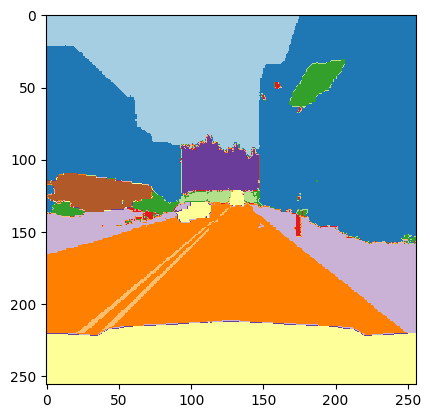

In [ ]:
pred= pred.detach().cpu()
plt.imshow(pred, cmap="Paired")

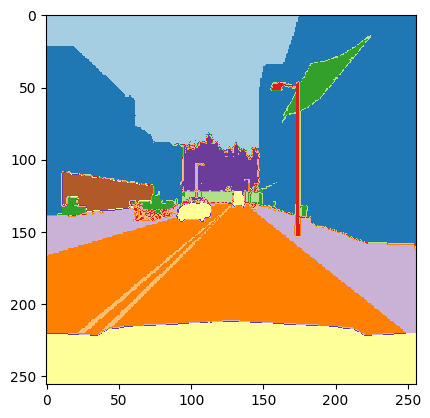

In [ ]:
plt.imshow(label, cmap="Paired")

# Testing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
!cp  /content/drive/MyDrive/thesis/Model_Weights -r /content

In [27]:
#step_4:
model_save_path = '/content/Model_Weights/Model_Weights/segnet_model/segnet_model_epoch30.pth'
model_save_dic= torch.load(model_save_path )
segnet_model.load_state_dict(model_save_dic['segnet_model_state_dict'])

<All keys matched successfully>

In [28]:
# acc_train =  MulticlassAccuracy().to(device)
miou_test = MeanIoU(num_classes=13, per_class=True, include_background=True).to(device)
dice = Dice(num_classes=13, average='micro').to(device)


In [33]:
segnet_model.eval()

segnet_loss_test=0
miout= 0
dicet=0
with torch.no_grad():
  for image, label in tqdm(train_loader):
      image= image.to(device)
      label= label.to(device)

      # Get the prediction from the model
      pred= segnet_model(image)
      # Compute the loss between prediction and label using loss function
      segnet_loss_test= criterion(pred, label)

      pred = torch.argmax(softmax(pred),axis=1)
      # Compute the jaccard index between prediction and label using jaccard index function
      miout += miou_test(pred, label)

      # compute the accuracy between prediction and label (add sum to the variable)
      dicet += dice(pred, label).item()
      #print(dicet)

# Append the loss to the validation loss list
print(segnet_loss_test.item()/len(test_loader))
# printing the mIoU (average jaccard index) to val mIoU list
print(f"the mean IOU {miou_test.compute()}")
# Append the average accuray to the val accuracy list
print(f" the dice coefficient is {dice.compute()}")


  0%|          | 0/375 [00:00<?, ?it/s]

0.0026305298805236817
the mean IOU tensor([0.9400, 0.6340, 0.2064, 0.2305, 0.0547, 0.0814, 0.4178, 0.9171, 0.7368,
        0.6997, 0.9752, 0.3168, 0.1212], device='cuda:0')
 the dice coefficient is 0.9130068421363831


# Generate masks

In [ ]:
# Get a back of images and labels
batch_img, batch_label = next(iter(test_loader))

In [ ]:
# Get one image and one label from the batch of images and labels
img = batch_img[0]
label = batch_label[0]

In [ ]:
# Change shape from (3, 60, 80) to (1, 3, 60, 80) so our pytorch neural network does not throw a shape error
# shape error meaning: expected 4D input got 3D instead
img = img.unsqueeze(0)

In [ ]:
# Generate a prediction
pred = segnet_model(img.to(device))

In [ ]:
# Change shape of prediction from (1, 13, 60, 80) to (13, 60, 80)
pred = pred.squeeze()

In [ ]:
softmax = nn.Softmax(dim=0)
pred= torch.argmax(softmax(pred), dim=0)

In [ ]:
# Convert the prediction from pytorch tensor to numpy array
pred = pred.detach().cpu()

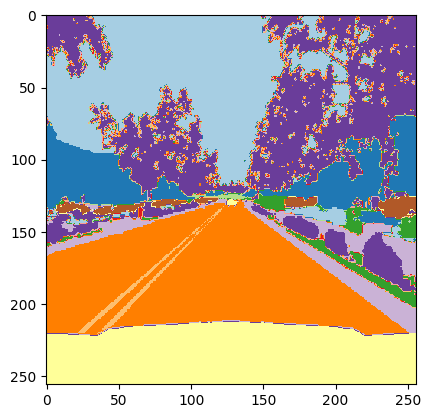

In [ ]:
# Finally display the mask
plt.imshow(pred, cmap="Paired")

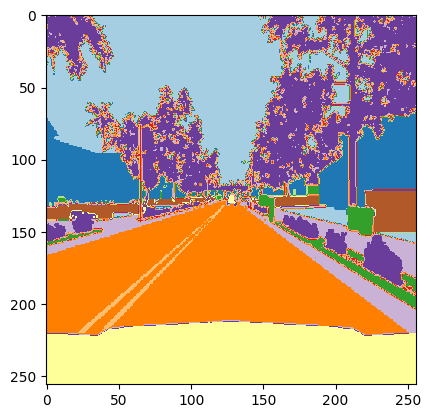

In [ ]:
plt.imshow(label, cmap="Paired")